In [1]:
import os
import tomopy
import numpy as np
import matplotlib.pyplot as plt
import sys
root_folder = os.path.dirname(os.getcwd())
sys.path.append(root_folder)
import utilities as rocku
import dxchange
import algotom.io.loadersaver as losa
import algotom.prep.correction as corr
import algotom.io.converter as conv
import algotom.prep.calculation as calc
import algotom.rec.reconstruction as rec
import bm3d_streak_removal as bm3d
import h5py as h5f
from tqdm import tqdm
import timeit
import multiprocessing as mp
import svmbir
import ast
from pprint import pprint
from skimage.measure import profile_line
# %matplotlib notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
ncore = mp.cpu_count()
print("CPU cores:", ncore)

CPU cores: 256


# Workflow starts here!

In [2]:
###################### need to change start
instrument = "/HFIR/CG1D"
ipts="32203"
###################### need to change end

In [3]:
# hdf5_loc = "/netdisk/y9z/IPTS-"+ipts+"/hdf5/"
hdf5_loc = instrument + "/IPTS-"+ipts+"/shared/autoreduce/hdf5/"
sorted(os.listdir(hdf5_loc))

['2024_03_01_carbon_fiber_high_res_bottom.h5',
 '2024_03_01_carbon_fiber_high_res_top.h5',
 '2024_07_24_carbon_composite_gridrec.h5',
 '2024_07_24_carbon_composite_sample1_gridrec.h5']

In [12]:
###################### need to change start
hdf5_name = "2024_07_24_carbon_composite_sample1_gridrec"
hdf5 = hdf5_loc + hdf5_name + ".h5"
num_of_str_to_rmv = 1
###################### need to change end
sample_name = rocku.hdf5_to_sample_name(hdf5_name, num_of_str_to_rmv)
instrument = "/HFIR/CG1D"
# instrument = "/SNS/VENUS"
svmbir_path = instrument + "/IPTS-"+ipts+"/shared/autoreduce/svmbir/"
sample_name

'2024_07_24_carbon_composite_sample1'

# Load hdf5 file

In [13]:
losa.get_hdf_tree(hdf5)
history_dict_str = losa.load_hdf(hdf5, key_path='tomo/recon/history')[0]
history_dict = ast.literal_eval(history_dict_str.decode("utf-8"))
pprint(history_dict)
#########################
proj_mlog_to_recon = losa.load_hdf(hdf5, key_path='tomo/proj/proj_mlog_to_recon')
# sino_mlog = losa.load_hdf(hdf5, key_path='tomo/sino/sino_mlog')
sino_mlog_to_recon = losa.load_hdf(hdf5, key_path='tomo/sino/sino_mlog_to_recon')
proj_norm_to_recon = np.exp(np.negative(proj_mlog_to_recon))
sino_norm_to_recon = np.moveaxis(proj_norm_to_recon, 1, 0)
ang_deg = losa.load_hdf(hdf5, key_path='tomo/info/ang_deg')
ang_rad = losa.load_hdf(hdf5, key_path='tomo/info/ang_rad')
proj000_idx = losa.load_hdf(hdf5, key_path='tomo/info/proj000_idx')[0]
proj180_idx = losa.load_hdf(hdf5, key_path='tomo/info/proj180_idx')[0]
# proj360_idx = losa.load_hdf(hdf5, key_path='tomo/info/proj360_idx')[0]
proj360_idx = proj180_idx * 2
rot_center_used = history_dict['rot_center']
rot_center_180 = history_dict['rot_center_180']
rot_center_360 = history_dict['rot_center_360']
pixel_size_um = history_dict['pixel_size_um']
gamma_diff = history_dict['gamma_diff']
# recon_hdf5 = losa.load_hdf(hdf5, key_path='tomo/recon/recon_volume')
if history_dict['recon_crop']:
    recon_crop = True
    recon_crop_roi_dict = history_dict['recon_crop_roi']
    recon_crop_left = history_dict['recon_crop_roi']['left']
    recon_crop_right = history_dict['recon_crop_roi']['right']
    recon_crop_top = history_dict['recon_crop_roi']['top']
    recon_crop_bottom = history_dict['recon_crop_roi']['bottom']
else:
    recon_crop = False
    recon_crop_left = None
    recon_crop_right = None
    recon_crop_top = None
    recon_crop_bottom = None

 tomo
    │
    ├── info
    │   │
    │   ├── ang_deg (474,)
    │   ├── ang_rad (474,)
    │   ├── fname (474,)
    │   ├── proj000_idx (1,)
    │   └── proj180_idx (1,)
    ├── proj
    │   │
    │   ├── proj_mlog_to_recon (474, 2140, 650)
    │   └── proj_norm (474, 2140, 650)
    ├── raw_ref
    │   │
    │   ├── dc_max (6400, 6400)
    │   ├── ob_min (6400, 6400)
    │   ├── proj_crop_roi_min (4280, 1300)
    │   └── proj_min (6400, 6400)
    ├── recon
    │   │
    │   ├── history (1,)
    │   ├── recon_unit (1,)
    │   └── recon_volume (2140, 400, 400)
    └── sino
        │
        ├── sino_mlog (2140, 474, 650)
        └── sino_mlog_to_recon (2140, 474, 650)
{'crop': True,
 'crop_roi': {'bottom': 6200, 'left': 1000, 'right': 2300, 'top': 1920},
 'gamma_diff': 20,
 'gamma_filter': True,
 'minus_log': True,
 'normalization': True,
 'pixel_bin_size': 2,
 'pixel_size_um': 31.94,
 'recon_algo': 'gridrec',
 'recon_crop': True,
 'recon_crop_roi': {'bottom': 520, 'left': 120, 'right

Text(0.5, 1.0, 'Sino norm')

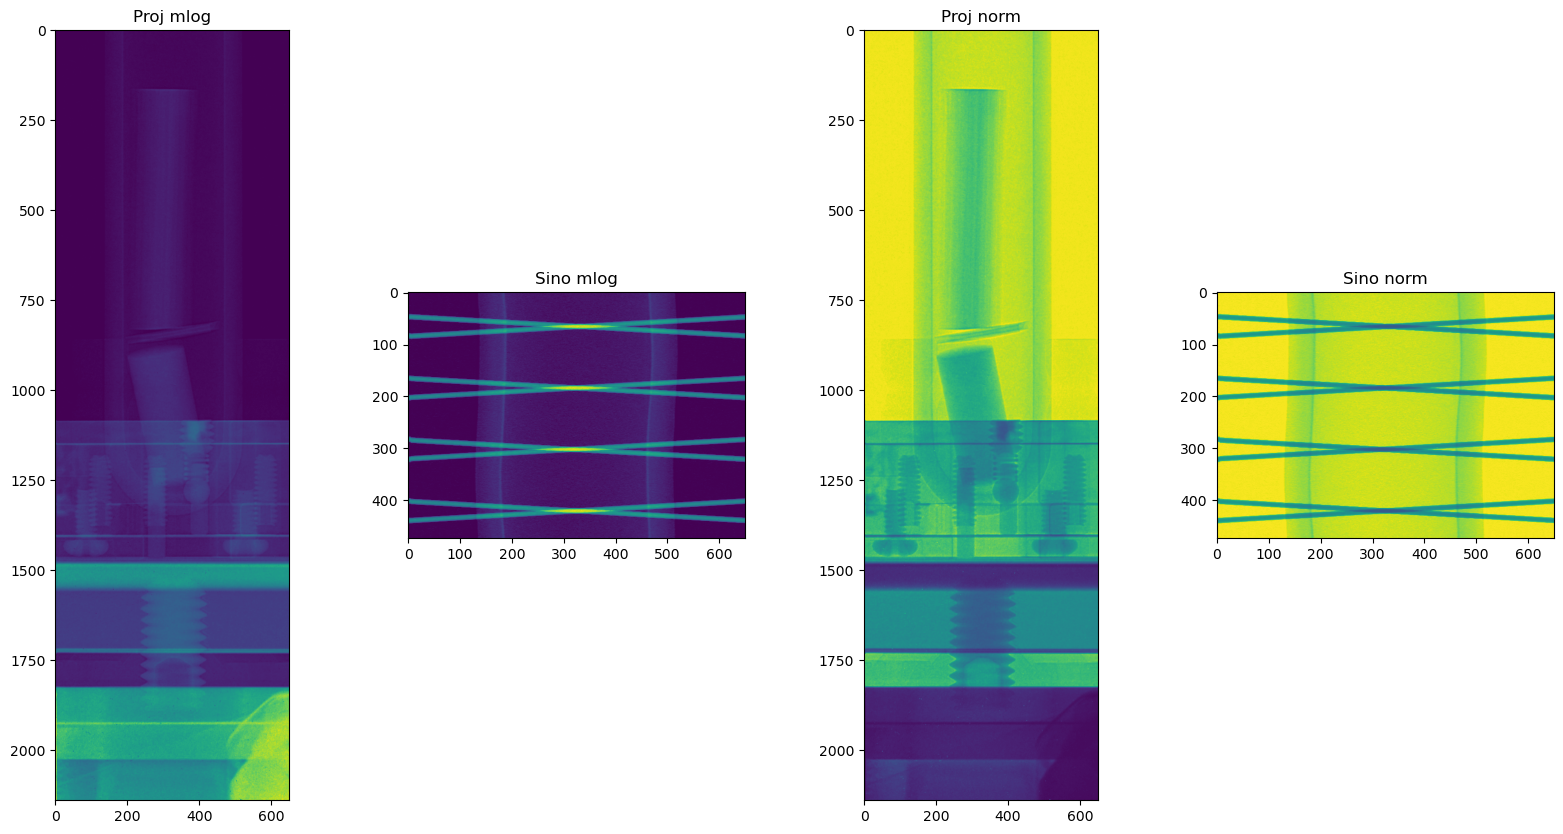

In [14]:
###################### need to change start
idx = 100
###################### need to change end
f, ax = plt.subplots(1, 4, figsize=(20, 10))
ax[0].imshow(proj_mlog_to_recon[idx], vmin=0)
ax[0].set_title('Proj mlog')
ax[1].imshow(sino_mlog_to_recon[idx], vmin=0)
ax[1].set_title('Sino mlog')
ax[2].imshow(proj_norm_to_recon[idx], vmin=0)
ax[2].set_title('Proj norm')
ax[3].imshow(sino_norm_to_recon[idx], vmin=0)
ax[3].set_title('Sino norm')

# Reconstruction

## Preview recon algorithms

Center of rotation 324.5


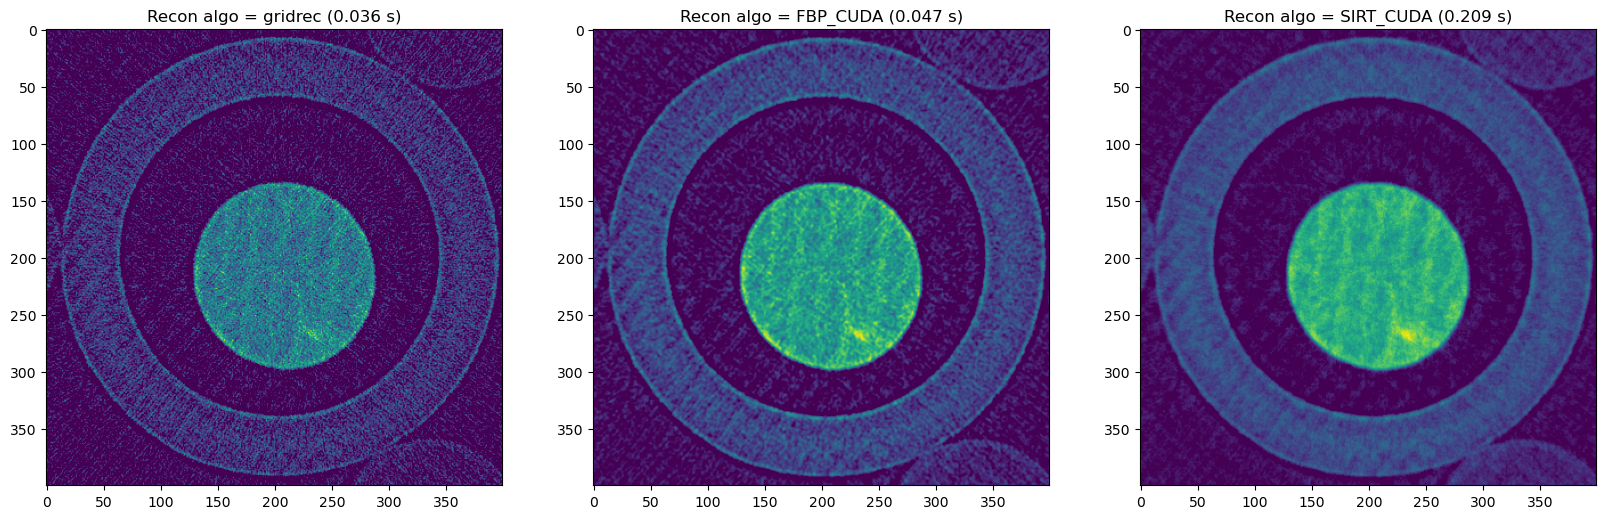

In [15]:
slice_num = None
# slice_num = 1000 #292
full_360 = True
# full_360 = False
idx_offset = 0 # adding this many projections past 180 deg if full_360 is False
num_iter = 200 # for iterative recon only
recon_algo_list = ['gridrec',
                   # 'fbp', 
                   # 'FBP', 'SIRT', 'SART', 'ART', 'CGLS', 
                   'FBP_CUDA',
                   'SIRT_CUDA',
                   # 'SART_CUDA',
                   # 'CGLS_CUDA',
                   # 'svmbir',
                   ]
rot_center = rot_center_used
#######################
#######################
if full_360:
    start_ang_idx = proj000_idx
    end_ang_idx = proj360_idx + 1
else:
    start_ang_idx = proj000_idx
    end_ang_idx = proj180_idx + 1 + idx_offset
if slice_num is None:
    slice_num = int(proj_mlog_to_recon.shape[1]/2)
print("Center of rotation", rot_center)
# recon_crop_roi = {'bottom': 1400, 'left': 200, 'right': 1350, 'top': 250}
# recon_crop_left = recon_crop_roi['left']
# recon_crop_right = 1400
# recon_crop_top = recon_crop_roi['top']
# recon_crop_bottom = recon_crop_roi['bottom']
f, ax = plt.subplots(1, len(recon_algo_list), figsize=(20, 20))
for num, each_algo in enumerate(recon_algo_list):
    t0 = timeit.default_timer()
    rec_img1 = rocku.recon_a_slice(sino_norm_to_recon[slice_num,start_ang_idx:end_ang_idx,:], proj_mlog_to_recon[start_ang_idx:end_ang_idx,slice_num,:], 
                                   rot_center, ang_rad[start_ang_idx:end_ang_idx], each_algo, ncore, svmbir_path, num_iter=num_iter, apply_log=True)
    rec_img1 = rocku.crop(rec_img1, recon_crop_left, recon_crop_right, recon_crop_top, recon_crop_bottom, recon_crop)
    t1 = timeit.default_timer()
    if len(recon_algo_list)>1:
        ax[num].imshow(rec_img1, vmin=0)
        ax[num].set_title('Recon algo = {} ({} s)'.format(each_algo, round(t1-t0, 3)))
    else:
        ax.imshow(rec_img1, vmin=0)
        ax.set_title('Recon algo = {} ({} s)'.format(each_algo, round(t1-t0, 3)))

# Beam Hardening correction

In [16]:
###################### need to change start
# bh_corr = True
bh_corr = False
line_loc = 220
# bh_q_list = [0.005]
bh_q_list = [0.05, 0.2, 0.4, 0.8, 1.6]
bh_n_list = [2]
# bh_n_list = [2, 4, 8, 16, 32]
# bh_opt = True #True: Curve towards 0.0. False: Curve towards 1.0.
bh_opt = False #True: Curve towards 0.0. False: Curve towards 1.0.
# recon_algo = 'gridrec'
recon_algo = 'fbp'
# recon_algo = 'SIRT_CUDA'
# recon_algo = 'svmbir'
###################### need to change end
if bh_corr:
    param_list = []
    for each_q in bh_q_list:
        for each_n in bh_n_list:
            _param = (each_q, each_n)
            param_list.append(_param)
    f, ax = plt.subplots(len(param_list)+1, 2, figsize=(15, 5*len(param_list)+1))
    rec_img1 = rocku.recon_a_slice(sino_norm_to_recon[slice_num,start_ang_idx:end_ang_idx,:], proj_mlog_to_recon[start_ang_idx:end_ang_idx,slice_num,:], 
                                       rot_center, ang_rad[start_ang_idx:end_ang_idx], recon_algo, ncore, svmbir_path, num_iter=num_iter, apply_log=True)
    rec_img1 = rocku.crop(rec_img1, recon_crop_left, recon_crop_right, recon_crop_top, recon_crop_bottom, recon_crop)
    start = (line_loc, 0)
    end = (line_loc, rec_img1.shape[1]-1)
    profile = profile_line(rec_img1, start, end)
    ax[0][0].imshow(rec_img1, vmin=0)
    ax[0][0].set_title('No BH correction')
    ax[0][0].plot([start[1], end[1]], [start[0], end[0]], 'r')
    ax[0][1].set_title('Profile')
    ax[0][1].plot(profile)
    t0 = timeit.default_timer()
    for num, e_param in enumerate(param_list):
        sino_norm_to_recon_bh_corr = corr.beam_hardening_correction(mat=sino_norm_to_recon[slice_num, start_ang_idx:end_ang_idx,:], q=e_param[0], n=e_param[1], opt=bh_opt)
        proj_norm_to_recon_bh_corr = corr.beam_hardening_correction(mat=proj_norm_to_recon[start_ang_idx:end_ang_idx,slice_num,:], q=e_param[0], n=e_param[1], opt=bh_opt)
        proj_mlog_to_recon_bh_corr = -np.log(proj_norm_to_recon_bh_corr)
        rec_img1 = rocku.recon_a_slice(sino_norm_to_recon_bh_corr, proj_mlog_to_recon_bh_corr, 
                                       rot_center, ang_rad[start_ang_idx:end_ang_idx], recon_algo, ncore, svmbir_path, num_iter=num_iter, apply_log=True)
        rec_img1 = rocku.crop(rec_img1, recon_crop_left, recon_crop_right, recon_crop_top, recon_crop_bottom, recon_crop)
        profile = profile_line(rec_img1, start, end)
        ax[num+1][0].imshow(rec_img1, vmin=0)
        ax[num+1][0].set_title('BH corrected (q={}, n={})'.format(e_param[0], e_param[1]))
        ax[num+1][0].plot([start[1], end[1]], [start[0], end[0]], 'r')
        ax[num+1][1].set_title('Profile')
        ax[num+1][1].plot(profile)
    t1 = timeit.default_timer()
    print("Time: {} mins".format((t1-t0)/60))

In [17]:
if bh_corr:
    bh_q = 0.8
    bh_n = 2
    proj_norm_to_recon_bh_corr = corr.beam_hardening_correction(mat=proj_norm_to_recon, q=bh_q, n=bh_n, opt=bh_opt)
    sino_norm_to_recon_bh_corr = np.moveaxis(proj_norm_to_recon_bh_corr, 1, 0)
    proj_mlog_to_recon_bh_corr = -np.log(proj_norm_to_recon_bh_corr)
    history_dict = rocku.log(history_dict, 'BH_corr', bh_corr)
    if bh_corr:
        bh_corr_param = {
            'q': bh_q,
            'n': bh_n,
            'opt': bh_opt,
        }
        history_dict = rocku.log(history_dict, 'BH_corr_param', bh_corr_param)
    history_dict

In [18]:
# recon_algo = 'FBP_CUDA'
recon_algo = 'SIRT_CUDA'
# recon_algo = 'svmbir'
# recon_algo = 'fbp'
#####['gridrec','fbp', 'FBP', 'SIRT', 'SART', 'ART', 'CGLS', 'FBP_CUDA','SIRT_CUDA','SART_CUDA','CGLS_CUDA','svmbir',]

slice_by_slice = True
# slice_by_slice = False

name_str = None
# name_str = 'test'
# name_str = 'lamino'
############################################################
pix_um = pixel_size_um # um
save_loc = instrument + "/IPTS-"+ipts+"/shared/processed_data/rockit/"
num_proj = len(ang_rad[start_ang_idx:end_ang_idx])
if name_str is not None:
    save_name_str = "_".join([sample_name, name_str, "{}proj".format(num_proj), recon_algo])# + "_roi"
else:
    save_name_str = "_".join([sample_name, "{}proj".format(num_proj), recon_algo])# + "_roi"
if bh_corr:
    save_name_str = save_name_str + '_BH_corrected'
save_to = save_loc + save_name_str
##################################
if bh_corr:
    sino_norm_final = sino_norm_to_recon_bh_corr[:]
    proj_mlog_final = proj_mlog_to_recon_bh_corr[:]
else:
    sino_norm_final = sino_norm_to_recon[:]
    proj_mlog_final = proj_mlog_to_recon[:]
if slice_by_slice:
    rocku.recon_slice_by_slice(sino_norm_final, proj_mlog_final, rot_center, ang_rad, start_ang_idx, end_ang_idx, recon_algo, ncore, svmbir_path, save_to, 
                               recon_crop=recon_crop, recon_crop_roi_dict=recon_crop_roi_dict, pix_um=pix_um, num_iter=num_iter, apply_log=True)
else:
    recon = rocku.recon_full_volume(proj_mlog_final, rot_center, ang_rad, start_ang_idx, end_ang_idx, recon_algo, ncore, svmbir_path, pix_um=pix_um, num_iter=num_iter, apply_log=False)
history_dict = rocku.log(history_dict, 'recon_algo', recon_algo)
history_dict = rocku.log(history_dict, 'recon_num_iter', num_iter)
history_dict

Slice by slice saving to: /HFIR/CG1D/IPTS-32203/shared/processed_data/rockit/2024_07_24_carbon_composite_sample1_473proj_SIRT_CUDA


100%|███████████████████████████████████████| 2140/2140 [07:38<00:00,  4.66it/s]

Time cost 7.645978954917519 min


{'crop': True,
 'crop_roi': {'left': 1000, 'right': 2300, 'top': 1920, 'bottom': 6200},
 'gamma_filter': True,
 'gamma_diff': 20,
 'normalization': True,
 'pixel_bin_size': 2,
 'minus_log': True,
 'rot_center_360': 325.0,
 'rot_center_180': 324.5,
 'rot_center': 324.5,
 'ring_removal': 'bm3dgpu',
 'pixel_size_um': 31.94,
 'recon_unit': 'cm-1',
 'recon_algo': 'SIRT_CUDA',
 'recon_crop': True,
 'recon_crop_roi': {'left': 120, 'right': 520, 'top': 120, 'bottom': 520},
 'recon_num_iter': 200}

In [11]:
if not slice_by_slice:
    recon_max = np.mean(recon, axis=0)
    plt.imshow(recon_max)#, vmax=2)
    plt.colorbar()
    plt.show()

In [12]:
if not slice_by_slice:
    recon_max_crop = rocku.crop(recon_max, recon_crop_left, recon_crop_right, recon_crop_top, recon_crop_bottom, recon_crop)
    if recon_crop:
        print("Recon ROI:")
        plt.imshow(recon_max_crop)#, vmax=2)
        plt.colorbar()
        plt.show()

# Export recon files

In [13]:
if not slice_by_slice:
    print("Saving to: {}".format(save_to))
    recon = rocku.crop(recon, recon_crop_left, recon_crop_right, recon_crop_top, recon_crop_bottom, recon_crop)
    dxchange.write_tiff_stack(recon, fname=save_to + "/recon", overwrite=True, digit=4)

# Export HDF5

In [17]:
output_hdf5_dir = instrument + "/IPTS-"+ipts+"/shared/autoreduce/hdf5/"
output_hdf5 = output_hdf5_dir + save_name_str + '_BH_corr.h5'
print(output_hdf5)

/HFIR/CG1D/IPTS-32328/shared/autoreduce/hdf5/2024_03_11_3D_stage2_424proj_gridrec_BH_corrected_BH_corr.h5


In [18]:
with h5f.File(output_hdf5, mode='a') as f:
    f.create_group('tomo/recon')
    f.create_dataset('tomo/recon/recon_volume_BH', data=recon)
    f.create_dataset('tomo/recon/history', data=(str(history_dict),))